# Install and Import Required Library

In [1]:
!pip install --q wandb tensorflow matplotlib pillow huggingface_hub

In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from urllib.request import urlopen
from io import BytesIO
import os

from zipfile import ZipFile

import wandb
from wandb.integration.keras import WandbMetricsLogger

# Download and Extract Dataset

In [4]:
!gdown 1JBN-6FYKXuKZkLAIvOLrk322E27TEP6r

with ZipFile(file="./dataset-resized-up.zip", mode='r') as zObject:
    zObject.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=1JBN-6FYKXuKZkLAIvOLrk322E27TEP6r
From (redirected): https://drive.google.com/uc?id=1JBN-6FYKXuKZkLAIvOLrk322E27TEP6r&confirm=t&uuid=0f94238b-5552-4490-bcb5-95e8dd1239bd
To: /content/dataset-resized-up.zip
100% 42.9M/42.9M [00:01<00:00, 26.8MB/s]


# Initiate W&B Config

In [5]:
run = wandb.init(
    project="trash-classification-nafis",
    config={
        "learning_rate": 0.001,
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size" : 16
    }
)

config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nafis252 (nafis252-personal-use). Use `wandb login --relogin` to force relogin


# Data Preprocessing

## This is the steps that i used for processing the data:
1. Data will be split with 70:30 ratio.
2. Image size will be reduced into (224,224) pixel using lanczos5 interpolation mode.
3. Data will be augmented using RandomRotation and RandomFlip layer to prevent overfitting.
4. Data will be normalized using Rescaling layer with values range from (-1,1) because it can improve convergence, and ensure a fair comparison between features.
5. Data will turned into batch with size of 16

In [6]:
data_path = "./dataset-resized"

In [7]:
# Load data directly from folder into tensorflow

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=(224, 224),
    interpolation="lanczos5",
    batch_size=config.batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    interpolation="lanczos5",
    batch_size=config.batch_size
)

Found 2527 files belonging to 6 classes.
Using 1769 files for training.
Found 2527 files belonging to 6 classes.
Using 758 files for validation.


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


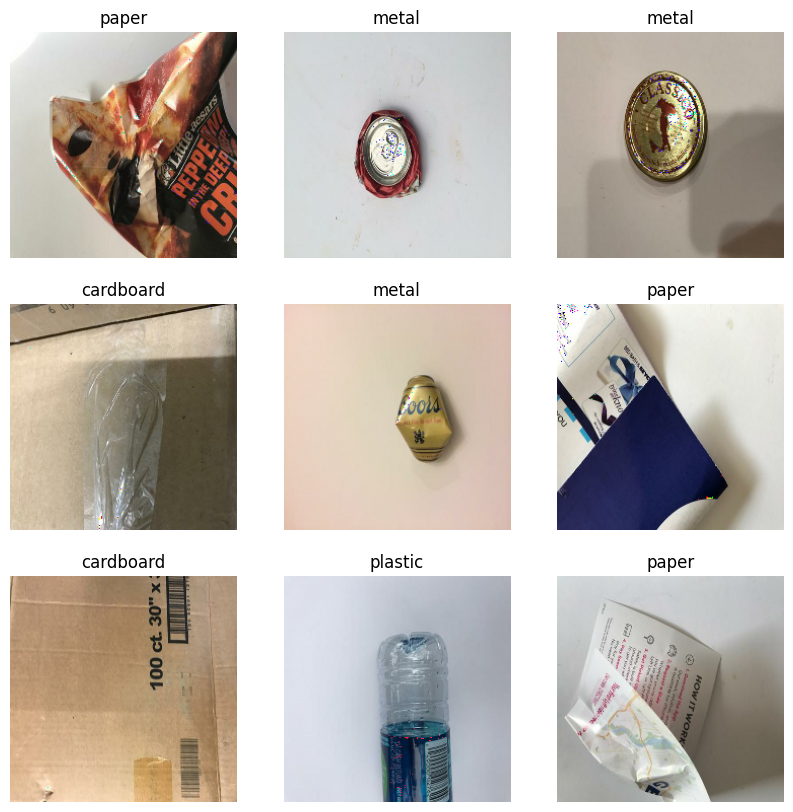

In [8]:
# Inspect dataset from batched dataset

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# Create cache folder to improve load data perfomance while training the model

os.makedirs("/content/cache/train")
os.makedirs("/content/cache/val")

train_ds = train_ds.cache("/content/cache/train").prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache("/content/cache/val").prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Experimentation

1. In this experimentation im using Skip Connection Technique introduced by He et al. in the ResNet architecture.
The benefits of using this technique is:
  - it can mitigate exploding gradients, because it will bypass intermediate layers by adding the input of a layer directly to its output.
  - facilitates training of deeper networks without performance degradation, which in this case im only using a small model.
  - it can help the network converge faster by ensuring stable gradient flow and efficient feature learning.

2. For augmentation technique, i implemented augmentation directly into model layer by using tf.keras.layers because it will use GPU to process augmentation which will improve model training time.

3. Rather than using ReLU activation functions for CNN layer, im using Mish activation functions because unlike ReLU, which zeros out all negative inputs, Mish retains small negative values. Negative values can carry useful information, and leading to better feature representation.

4. Im using BatchNormalization for faster model convergence helps prevent overfitting by reducing the model's dependence on specific activation patterns which will make the model robust. (source : datacamp)

5. Im using ReduceLROnPlateau to prevent spiking loss performance while gradient updates by Adam Optimizers

In [10]:
def AugmentRescale(x):
  x = tf.keras.layers.RandomRotation(0.2)(x)
  x = tf.keras.layers.RandomFlip('horizontal')(x)
  x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)
  return x

def CustomBlock(x, filter):
  x_copy = x

  x = tf.keras.layers.Conv2D(filters = filter, kernel_size = (1,1), padding = "valid", use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization(axis=3, epsilon=1e-5)(x)
  x = tf.keras.layers.Activation("mish")(x)

  x = tf.keras.layers.Conv2D(filters = filter, kernel_size = (3,3), padding = "same", use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization(axis=3, epsilon=1e-5)(x)
  x = tf.keras.layers.Activation("mish")(x)

  x_copy = tf.keras.layers.Conv2D(filters = filter, kernel_size = (1,1), padding = "valid", use_bias=False)(x_copy)

  x = tf.keras.layers.Add()([x, x_copy])
  x = tf.keras.layers.Activation("mish")(x)
  return x

In [11]:
def CustomNet(input_shape=(None, None, 3), num_classes=6, model_name="CustomNet"):
  inputs = tf.keras.layers.Input(shape=input_shape)
  x = AugmentRescale(inputs)

  x = tf.keras.layers.Conv2D(filters=16, kernel_size=(7,7), padding="same")(x)
  x = tf.keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)
  x = tf.keras.layers.Activation("mish")(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)

  x = CustomBlock(x, 16)
  x = CustomBlock(x, 32)
  x = CustomBlock(x, 64)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(64, use_bias = False)(x)
  x = tf.keras.layers.BatchNormalization(center = True, scale = False)(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Dense(num_classes, activation="softmax", name="predictions")(x)

  model = tf.keras.Model(inputs=inputs, outputs=x, name=model_name)
  return model

In [12]:
tf.keras.backend.clear_session()
model = CustomNet(input_shape=(224,224,3))

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    loss=config.loss,
    metrics=[config.metric]
)

callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Use validation loss to adjust learning rate
    factor=0.5,            # Reduce learning rate by half
    patience=3,            # Wait for 3 epochs of no improvement
    min_lr=1e-6            # Minimum learning rate
)

In [14]:
history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=config.epoch,
      callbacks=[callback, WandbMetricsLogger()]
)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 220ms/step - accuracy: 0.3558 - loss: 1.6423 - val_accuracy: 0.2916 - val_loss: 1.6713 - learning_rate: 0.0010
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5127 - loss: 1.2664 - val_accuracy: 0.4169 - val_loss: 1.5285 - learning_rate: 0.0010
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.5806 - loss: 1.1353 - val_accuracy: 0.4208 - val_loss: 1.4707 - learning_rate: 0.0010
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.6342 - loss: 1.0497 - val_accuracy: 0.4565 - val_loss: 1.4657 - learning_rate: 0.0010
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.6598 - loss: 0.9744 - val_accuracy: 0.5844 - val_loss: 1.1334 - learning_rate: 0.0010
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.6548 - loss: 0.9428 - val_accuracy: 0.6649 - val_loss: 0.9610 - learning_rate: 0.0010
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.6

# Save and Upload model

In [16]:
# Logging evaluation score
eval_loss, eval_acc = model.evaluate(val_ds)

wandb.log({
    "eval_loss": eval_loss,
    "eval_acc": eval_acc
})

# Save model locally
path = "./models-trash-classification.keras"
weight_path = "./models-trash-classification.weights.h5"
model.save(path)
model.save_weights(weight_path)

# Save model to W&B
model_path = "./models-trash-classification.keras"
registered_name = "trash-classification-dev"
run.link_model(path=path, registered_model_name=registered_name)

print(f"The model has been saved in W&B")

wandb.finish()

The model has been saved in W&B


epoch/accuracy,▁▃▄▅▅▅▅▅▆▆▇▇▇▇▇▇████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,████████▄▄▄▄▄▄▂▂▂▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▃▃▄▅▇▅▅▆▇▇▇▇▇▇▆█▇██
epoch/val_loss,█▇▆▆▄▃▅▅▃▂▂▂▂▂▂▄▂▂▁▁
eval_acc,▁
eval_loss,▁
epoch/accuracy,0.82646
epoch/epoch,19
epoch/learning_rate,0.00013


## Upload to HuggingFace repository

In [17]:
from huggingface_hub import HfApi, HfFolder, notebook_login

notebook_login()
api = HfApi()

In [18]:
repo_id = "TrashClassification"
token = HfFolder().get_token()
model_url = HfApi().create_repo(token=token, repo_id=repo_id, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
api.upload_file(
    path_or_fileobj="./models-trash-classification.keras",
    path_in_repo="models-trash-classification.keras",
    repo_id="Libidrave/" + repo_id,
    repo_type="model"
)

CommitInfo(commit_url='https://huggingface.co/Libidrave/TrashClassification/commit/e4a2d49ed5b5839169c13fb4ad09f94d4504f363', commit_message='Upload models-trash-classification.keras with huggingface_hub', commit_description='', oid='e4a2d49ed5b5839169c13fb4ad09f94d4504f363', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Libidrave/TrashClassification', endpoint='https://huggingface.co', repo_type='model', repo_id='Libidrave/TrashClassification'), pr_revision=None, pr_num=None)

In [22]:
api.upload_file(
    path_or_fileobj="./models-trash-classification.weights.h5",
    path_in_repo="models-trash-classification.weights.h5",
    repo_id="Libidrave/" + repo_id,
    repo_type="model"
)

models-trash-classification.weights.h5:   0%|          | 0.00/859k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Libidrave/TrashClassification/commit/91f0a87c3154d3a35b20e9ef99791a99d260fa54', commit_message='Upload models-trash-classification.weights.h5 with huggingface_hub', commit_description='', oid='91f0a87c3154d3a35b20e9ef99791a99d260fa54', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Libidrave/TrashClassification', endpoint='https://huggingface.co', repo_type='model', repo_id='Libidrave/TrashClassification'), pr_revision=None, pr_num=None)

Model Architecture and Layer Visualization

In [23]:
model.summary()

Model: "CustomNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation           │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, 224, 224, 3)    │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ random_flip[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │          2,368 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 16)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 16)   │            256 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 16)   │          2,304 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 16)   │            256 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 16)   │              0 │ activation_2[0][0],    │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 184,852 (722.08 KB)

 Trainable params: 61,414 (239.90 KB)

 Non-trainable params: 608 (2.38 KB)

 Optimizer params: 122,830 (479.81 KB)

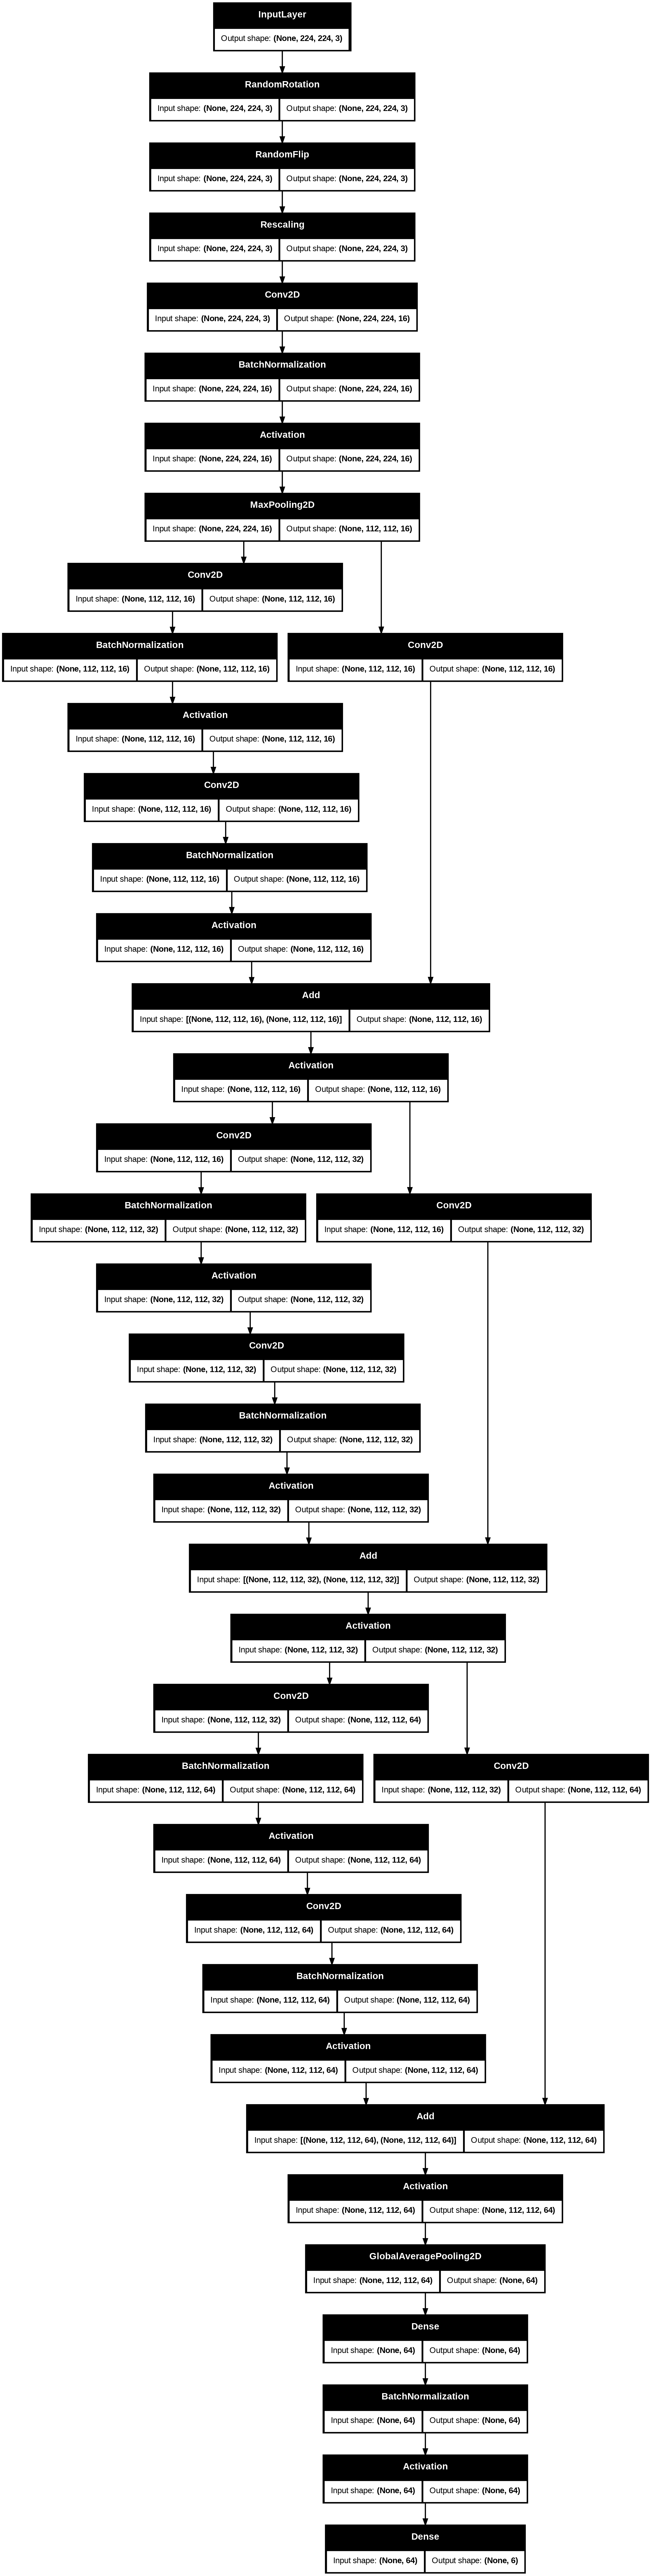

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Model testing

In [28]:
img_url = "https://beritausaha.com/wp-content/uploads/2022/08/Kardus-Bekas-1.jpg"
image_response = urlopen(img_url)
image_data = image_response.read()
image = Image.open(BytesIO(image_data))
image = image.resize((224, 224))

img_array = tf.keras.utils.img_to_array(image)
img_array = tf.cast(tf.expand_dims(img_array, 0), tf.dtypes.float32)

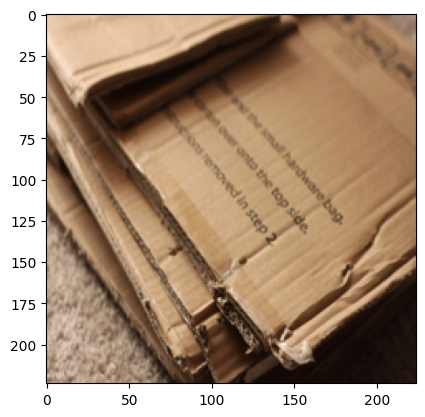

In [29]:
plt.imshow(tf.cast(image, tf.dtypes.uint8))
plt.show()

In [30]:
predictions = model.predict(img_array, batch_size=1)

y_pred_idx = np.argmax(predictions)
confidence = 100 * np.max(predictions)  # Get the maximum value from the predictions array

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[y_pred_idx], confidence)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
This image most likely belongs to cardboard with a 88.37 percent confidence.
